# Predictive Maintenance of Aircraft Engines
_**Making a Prediction of When An Engine Fails**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the classifier model](#Training-the-classifier-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


Predictive Maintenance using Machine Learning on Sagemaker

Project Goal
 
Predict whether the engine will fail at certain life cycle and observed system parameters. 

Future engineering - Modeling Strategy 
    a. Analyze the dataset using pandas
    b. Decide impacting parameters along with target for prediction. 1 stands for fail; 0 stands for pass.
    c. Remove noise columns if decided having minimum impact on the final prediction result. 
    e. Divide up the training dataset into 80% training and 20% for testing validation. 

Implementation - Prepare Datasets 
To simplify the use case, we prepare the dataset in the following steps:
    a. concatenate four dataset into one dataset
    b. add two more attributes (condition and failure mode) to the concatenated dataset. We use binary value for each new attribute added. Condition 0 stands for sea level; 1 stands for six level; failure mode 0 stands for one; 1 stands for two.
    c. to ensure the data is well distributed, we will keep the four records closest to the failure record and label it as pass (0). We will label failure record as fail (1).  
    d. for this team exercise, we will only use the training dataset and discard the testing data. 
    
    
End Goal

Predict failure or pass for each engine at certain cycle point based on observed parameters.  


## Prequisites and Preprocessing

Prerequisites and Preprocessing
This notebook was created and tested on an ml.m4.xlarge notebook instance.
We need to add <Conditions> and <Fault Mode> to each of the dataset (test_FD001 - test_FD004, train_FD001 - train_FD004).


### Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [36]:
# Define IAM role
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import json
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker.predictor import csv_serializer
pd.set_option("display.max_rows", 200)

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

#ucket = sess.default_bucket() # Replace with your own bucket name if needed
bucket = 'preventivemaintenance'
print(bucket)
prefix = 'preventivemaintenance/supervised' #Replace with the prefix under which you want to store the data if needed

role = get_execution_role()

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
preventivemaintenance


### Data Preparation

Now we'll download a dataset from the web on which we want to train the text classification model. BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by "\__label\__".

In this example, let us train the text classification model on the [DBPedia Ontology Dataset](https://wiki.dbpedia.org/services-resources/dbpedia-data-set-2014#2) as done by [Zhang et al](https://arxiv.org/pdf/1509.01626.pdf). The DBpedia ontology dataset is constructed by picking 14 nonoverlapping classes from DBpedia 2014. It has 560,000 training samples and 70,000 testing samples. The fields we used for this dataset contain title and abstract of each Wikipedia article. 

In [4]:
%%time
!wget https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip

--2019-02-14 19:24:04--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘CMAPSSData.zip.9’

CMAPSSData.zip.9    100%[===================>]  11.85M  10.5MB/s    in 1.1s    

2019-02-14 19:24:05 (10.5 MB/s) - ‘CMAPSSData.zip.9’ saved [12425978/12425978]

CPU times: user 42.1 ms, sys: 11.3 ms, total: 53.4 ms
Wall time: 1.76 s


In [5]:
%%time
!unzip CMAPSSData.zip

Archive:  CMAPSSData.zip
replace Damage Propagation Modeling.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
CPU times: user 9.3 s, sys: 3.44 s, total: 12.7 s
Wall time: 9min 35s


In [8]:
!cat readme.txt

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine � i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. Th

### Data Ingestion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

The following step will concatenate the four datasets together, add necessary new attribute, and put the final predicted value in traning dataset. 

In [7]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'o_1', 'o_2', 'o_3'] + ['s{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

np.set_printoptions(suppress=True, threshold=10000)

def loadData(csv_file, c, m, base=0): 
    df = pd.read_csv(csv_file, sep=" ", header=None).drop(columns=[26, 27])
    df.columns = column_names
    df = df.groupby(id_col).apply(lambda group: group.iloc[-5:]).reset_index(drop=True)
    df.insert(2, 'mode', m)
    df.insert(2, 'condition', c)
    df.insert(0, 'target', c)
    df.loc[df.index%5==4, 'target'] = 1
    df.loc[df.index%5!=4, 'target'] = 0
    df[id_col] = df[id_col].astype(int) + base
    
    return df

df = pd.concat([loadData('train_FD001.txt', 0, 0), loadData('train_FD002.txt', 1, 0, 100), 
                loadData('train_FD003.txt', 0, 1, 200), loadData('train_FD004.txt', 1, 1, 300)])

df[500:520]

,target,unit_number,time,condition,mode,o_1,o_2,o_3,s1,s2,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,0,101,145,1,0,35.0007,0.8402,100.0,449.44,556.59,...,182.61,2387.77,8050.29,9.4189,0.02,338,2223,100.00,14.72,8.8240
1,0,101,146,1,0,10.0006,0.2516,100.0,489.05,605.94,...,370.52,2388.43,8113.02,8.7345,0.03,372,2319,100.00,28.16,16.9984
2,0,101,147,1,0,25.0005,0.6200,60.0,462.54,537.50,...,164.56,2027.97,7866.66,10.9764,0.02,310,1915,84.93,14.34,8.4476
3,0,101,148,1,0,0.0024,0.0013,100.0,518.67,643.73,...,519.76,2388.31,8115.88,8.5240,0.03,397,2388,100.00,38.55,23.0079
4,1,101,149,1,0,42.0017,0.8414,100.0,445.00,550.49,...,129.55,2387.40,8066.19,9.4765,0.02,332,2212,100.00,10.45,6.2285
5,0,102,265,1,0,10.0055,0.2514,100.0,489.05,605.84,...,370.12,2388.33,8156.23,8.7400,0.03,373,2319,100.00,28.36,16.9751
6,0,102,266,1,0,0.0006,0.0000,100.0,518.67,643.56,...,519.65,2388.21,8159.43,8.5163,0.03,395,2388,100.00,38.53,23.0970
7,0,102,267,1,0,25.0059,0.6200,60.0,462.54,537.55,...,164.64,2028.67,7896.86,11.0190,0.02,309,1915,84.93,14.21,8.5926
8,0,102,268,1,0,25.0001,0.6201,60.0,462.54,537.14,...,163.33,2028.65,7899.04,11.0400,0.02,310,1915,84.93,13.99,8.3873
9,1,102,269,1,0,42.0047,0.8411,100.0,445.00,550.11,...,129.76,2388.42,8110.26,9.4315,0.02,334,2212,100.00,10.56,6.2615


### Data Inspection 
We will analyze the data in the following steps.

,unit_number,time,condition,mode,o_1,o_2,o_3,s1,s2,s3,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,target
count,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,...,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000
mean,276.241185,224.176305,0.717913,0.492243,17.308946,0.410803,95.881523,485.817258,598.335190,1479.413822,...,2351.334874,8112.460722,9.088673,0.026085,363.921580,2275.033286,98.448364,25.770017,15.464265,0.200000
std,141.212291,66.412345,0.450079,0.500010,16.632388,0.367920,12.158080,30.443701,42.506755,118.399638,...,109.362156,89.066049,0.754709,0.004882,31.106631,140.760641,4.580557,11.661924,6.998722,0.400056
min,1.000000,124.000000,0.000000,0.000000,-0.006700,-0.000500,60.000000,445.000000,536.610000,1258.120000,...,2027.570000,7845.780000,8.156300,0.020000,307.000000,1915.000000,84.930000,10.220000,6.010500,0.000000
25%,178.000000,179.000000,0.000000,0.000000,0.001300,0.000200,100.000000,449.440000,550.640000,1367.860000,...,2388.150000,8079.070000,8.519200,0.020000,334.000000,2212.000000,100.000000,14.180000,8.513300,0.000000
50%,278.000000,205.000000,1.000000,0.000000,19.998200,0.620000,100.000000,489.050000,606.500000,1504.450000,...,2388.290000,8125.330000,8.969300,0.030000,370.000000,2319.000000,100.000000,25.120000,15.079800,0.000000
75%,372.000000,258.000000,1.000000,1.000000,35.002200,0.840000,100.000000,518.670000,643.460000,1600.390000,...,2388.510000,8176.850000,9.422900,0.030000,396.000000,2388.000000,100.000000,38.440000,23.065400,0.000000
max,549.000000,543.000000,1.000000,1.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1615.390000,...,2390.490000,8293.720000,11.065700,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500,1.000000


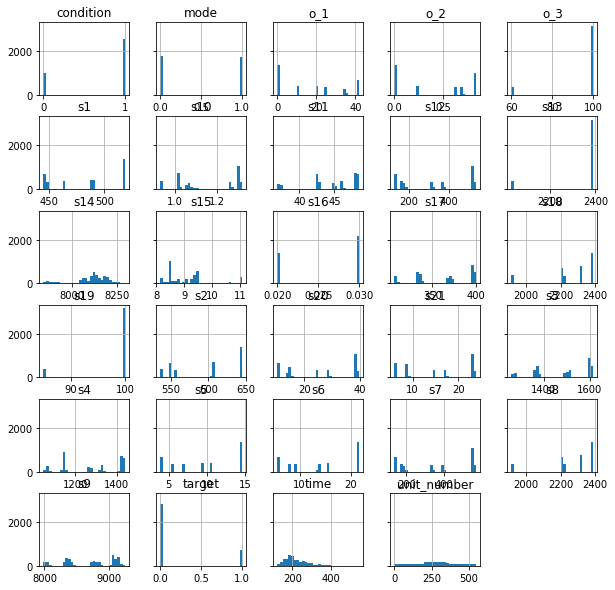

In [36]:
# analyze the data
for col in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[col], columns='% observations', normalize='columns'))
    
display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

,target,unit_number,time,condition,mode,o_1,o_2,o_3,s1,s2,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
target,1.000000,0.000000,0.015060,0.000000,0.000000,0.105901,0.043507,0.106743,-0.092124,-0.055721,...,-0.068426,0.106968,0.101828,-0.055216,-0.088713,-0.024316,0.029981,0.106743,-0.076257,-0.076286
unit_number,0.000000,1.000000,0.199079,0.558242,0.688694,0.367117,0.394145,-0.116208,-0.380187,-0.375820,...,-0.384692,-0.115493,-0.190162,0.234150,-0.280970,-0.365025,-0.280437,-0.116208,-0.380835,-0.380688
time,0.015060,0.199079,1.000000,-0.005463,0.298826,-0.021882,-0.021226,0.026172,0.019307,0.022039,...,0.038229,0.027339,0.164838,-0.122408,0.023166,0.029303,0.029201,0.026172,0.038927,0.038919
condition,0.000000,0.558242,-0.005463,1.000000,-0.009726,0.652432,0.699997,-0.212368,-0.676537,-0.667462,...,-0.700945,-0.211882,-0.407175,0.523740,-0.502835,-0.651733,-0.503137,-0.212368,-0.694972,-0.694992
mode,0.000000,0.688694,0.298826,-0.009726,1.000000,-0.011959,-0.012897,-0.008042,0.010440,0.005306,...,0.023797,-0.007451,0.059036,-0.086684,0.003737,0.006238,-0.000558,-0.008042,0.024631,0.024948
o_1,0.105901,0.367117,-0.021882,0.652432,-0.011959,1.000000,0.966465,-0.156747,-0.979762,-0.926064,...,-0.971734,-0.156434,-0.419742,0.630104,-0.891489,-0.880081,-0.621066,-0.156747,-0.977874,-0.977864
o_2,0.043507,0.394145,-0.021226,0.699997,-0.012897,0.966465,1.000000,-0.193099,-0.937506,-0.897605,...,-0.958141,-0.192631,-0.486766,0.676851,-0.810221,-0.869636,-0.624992,-0.193099,-0.959146,-0.959171
o_3,0.106743,-0.116208,0.026172,-0.212368,-0.008042,-0.156747,-0.193099,1.000000,0.259077,0.486203,...,0.357895,0.999991,0.830038,-0.832652,0.422341,0.593358,0.866674,1.000000,0.335840,0.335839
s1,-0.092124,-0.380187,0.019307,-0.676537,0.010440,-0.979762,-0.937506,0.259077,1.000000,0.969917,...,0.985143,0.258733,0.477971,-0.684058,0.923157,0.928991,0.706355,0.259077,0.987796,0.987783
s2,-0.055721,-0.375820,0.022039,-0.667462,0.005306,-0.926064,-0.897605,0.486203,0.969917,1.000000,...,0.981808,0.485886,0.641379,-0.828281,0.939903,0.989975,0.857249,0.486203,0.978600,0.978593


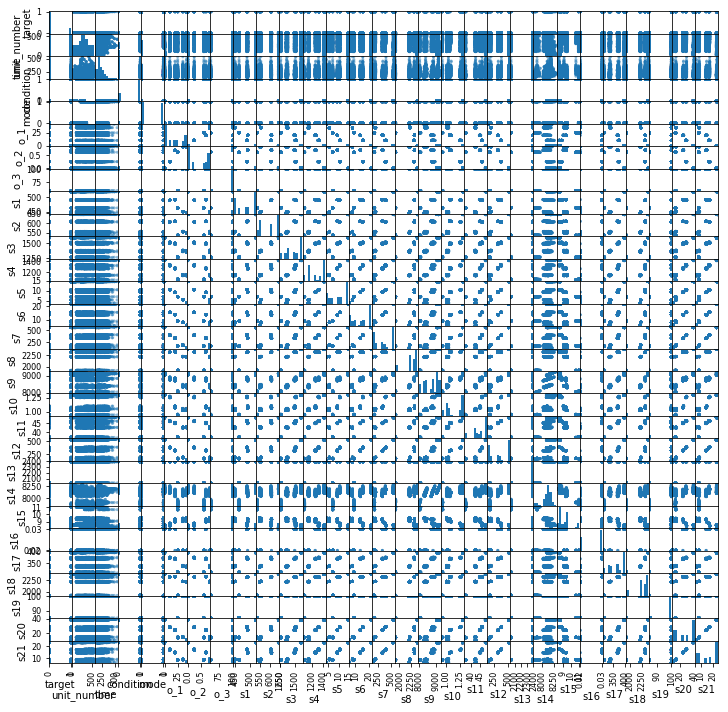

In [66]:
display(df.corr())
pd.plotting.scatter_matrix(df, figsize=(12, 12))
plt.show()

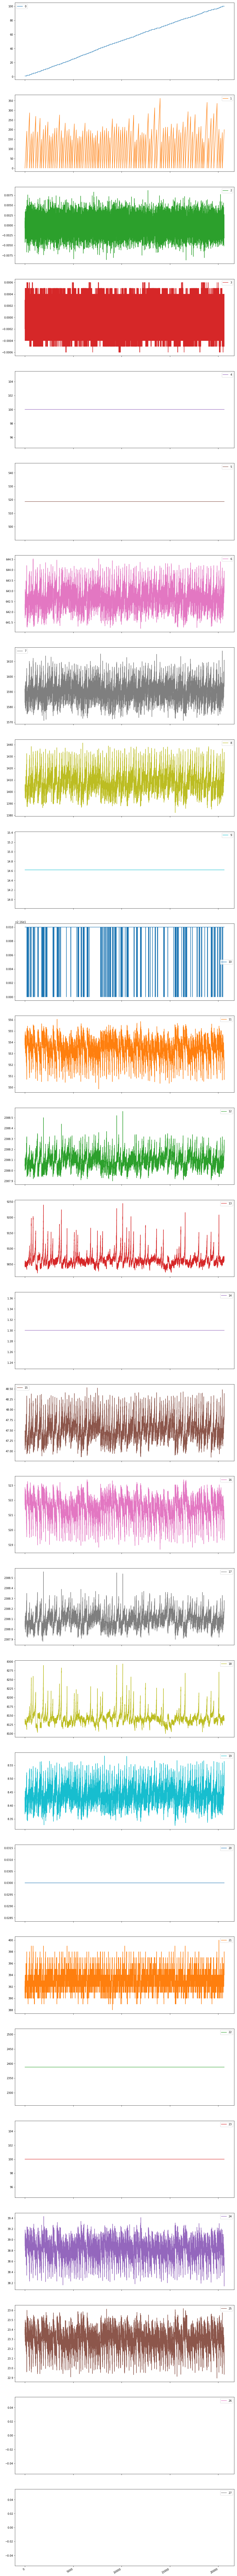

In [8]:
import matplotlib.pyplot as plt
data2 = pd.read_csv('train_FD001.txt', sep=" " , header=None) 
data2.plot(subplots=True, figsize=(15, 200));

In [53]:
df.shape

(3545, 29)

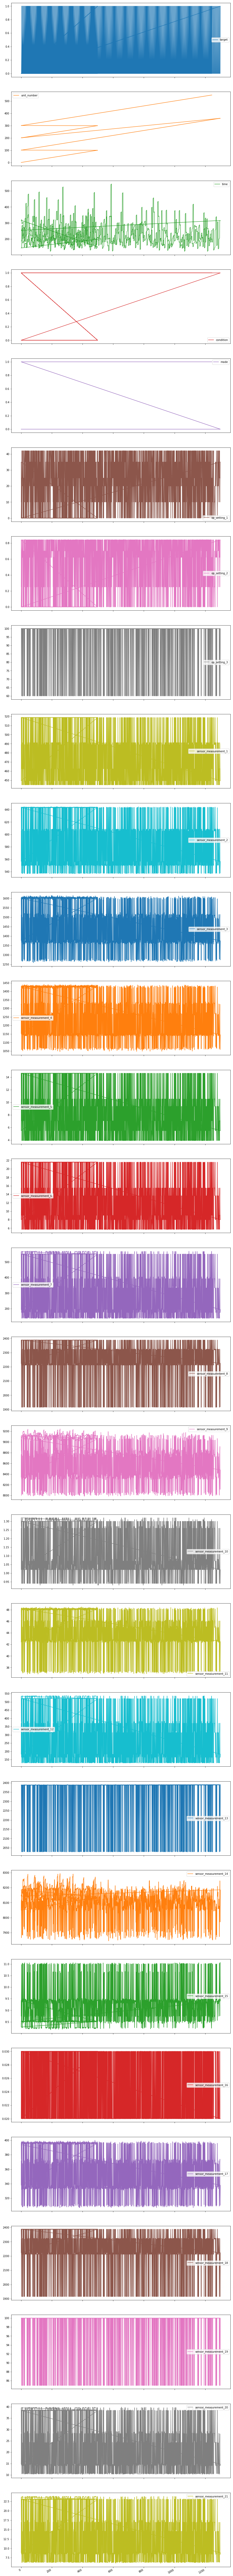

In [10]:
df.plot(subplots=True, figsize=(15, 200));

In [67]:
df.drop(columns=['s19', 's21', 's13']) #Drop the time series column

,target,unit_number,time,condition,mode,o_1,o_2,o_3,s1,s2,...,s9,s10,s11,s12,s14,s15,s16,s17,s18,s20
0,0,1,188,0,0,-0.0067,0.0003,100.0,518.67,643.75,...,9037.91,1.30,48.00,519.79,8117.69,8.5207,0.03,396,2388,38.51
1,0,1,189,0,0,-0.0006,0.0002,100.0,518.67,644.18,...,9044.55,1.30,48.08,519.58,8117.51,8.5183,0.03,395,2388,38.48
2,0,1,190,0,0,-0.0027,0.0001,100.0,518.67,643.64,...,9040.58,1.30,48.33,520.04,8112.58,8.5223,0.03,398,2388,38.49
3,0,1,191,0,0,-0.0000,-0.0004,100.0,518.67,643.34,...,9042.76,1.30,48.15,519.57,8114.61,8.5174,0.03,394,2388,38.45
4,1,1,192,0,0,0.0009,-0.0000,100.0,518.67,643.54,...,9033.22,1.30,48.25,520.08,8110.93,8.5113,0.03,396,2388,38.48
5,0,2,283,0,0,0.0046,0.0002,100.0,518.67,643.78,...,9084.13,1.30,48.21,520.07,8174.85,8.5199,0.03,398,2388,38.42
6,0,2,284,0,0,-0.0006,0.0001,100.0,518.67,643.91,...,9089.87,1.30,48.18,519.95,8166.83,8.5291,0.03,395,2388,38.23
7,0,2,285,0,0,-0.0007,0.0004,100.0,518.67,643.67,...,9098.67,1.30,48.27,519.91,8164.83,8.5242,0.03,396,2388,38.39
8,0,2,286,0,0,-0.0010,-0.0003,100.0,518.67,643.44,...,9102.01,1.30,48.14,519.51,8169.97,8.4932,0.03,395,2388,38.33
9,1,2,287,0,0,-0.0005,0.0006,100.0,518.67,643.85,...,9109.36,1.30,48.12,519.81,8175.57,8.5365,0.03,398,2388,38.43


In [9]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))], )
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [10]:
!wc -l test.csv
## Validate sample size of training and validation data sets  

355 test.csv


In [12]:
import datetime, time, sys, socket, os.path, getopt
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation.csv')).upload_file('validation.csv')

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [16]:
s3_input_train = sagemaker.s3_input(s3_data='s3://preventivemaintenance/preventivemaintenance/supervised/train.csv', content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://preventivemaintenance/preventivemaintenance/supervised/validation.csv', content_type='csv')
print(s3_input_train)
print(s3_input_validation)

In [17]:
#  Tuning hyperparameters in the model
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://preventivemaintenance/preventivemaintenance/supervised/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

print(s3_input_train)  # to validate that target exists
print(s3_input_validation)   # to validate that target exists
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


INFO:sagemaker:Creating training-job with name: xgboost-2019-02-14-19-43-29-999


2019-02-14 19:43:30 Starting - Starting the training job...
2019-02-14 19:43:31 Starting - Launching requested ML instances......
2019-02-14 19:44:38 Starting - Preparing the instances for training.........
2019-02-14 19:46:25 Downloading - Downloading input data...
2019-02-14 19:46:57 Training - Training image download completed. Training in progress.
2019-02-14 19:46:57 Uploading - Uploading generated training model
Arguments: train
[2019-02-14:19:46:51:INFO] Running standalone xgboost training.
[2019-02-14:19:46:51:INFO] File size need to be processed in the node: 0.52mb. Available memory size in the node: 8464.64mb
[2019-02-14:19:46:51:INFO] Determined delimiter of CSV input is ','
[19:46:51] S3DistributionType set as FullyReplicated
[19:46:51] 2481x28 matrix with 69468 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-02-14:19:46:51:INFO] Determined delimiter of CSV input is ','
[19:46:51] S3DistributionType set as FullyReplicated
[19:46:51] 

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [18]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-02-14-19-51-20-128
INFO:sagemaker:Creating endpoint with name xgboost-2019-02-14-19-43-29-999


---------------------------------------------------------------!

In [19]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

xgb_predictor.content_type = 'text/csv' 
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [20]:
def predict(data, rows=350):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

In [21]:
# Confusion matrix (cutoff at 0.50)
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions']) 

predictions,0.0,1.0
actual,,
0,254,14
1,61,26


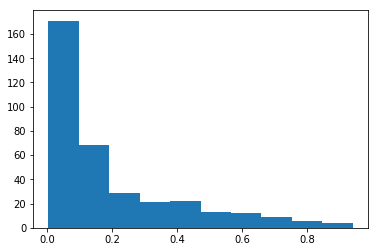

In [28]:
# Distribution of predictions
plt.hist(predictions)
plt.show()

In [29]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.1, 1, 0))

col_0,0,1
target,,
0,162,106
1,13,74


# Hyperparameter Tuning

In [35]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri('us-east-1', 'xgboost', repo_version='latest')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://preventivemaintenance/preventivemaintenance/supervised/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

In [37]:
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

In [38]:
objective_metric_name = 'validation:auc'

In [59]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=3)

In [63]:
s3_input_train = sagemaker.s3_input(s3_data='s3://preventivemaintenance/preventivemaintenance/supervised/train.csv'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://preventivemaintenance/preventivemaintenance/supervised/validation/'.format(bucket, prefix), content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-190214-2100


In [61]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [52]:
import boto3
import sagemaker
import os

region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')

tuning_job_name = 'YOUR-HYPERPARAMETER-TUNING-JOB-NAME'

In [54]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

ClientError: An error occurred (ValidationException) when calling the DescribeHyperParameterTuningJob operation: 1 validation error detected: Value 'YOUR-HYPERPARAMETER-TUNING-JOB-NAME' at 'hyperParameterTuningJobName' failed to satisfy constraint: Member must have length less than or equal to 32

Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [43]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

NameError: name 'tuning_job_result' is not defined

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record.

In [ ]:
result = linear_predictor.predict(train_set[0][30:31])
print(result)

OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

In [ ]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [ ]:
import pandas as pd

pd.crosstab(np.where(test_set[1] == 0, 1, 0), predictions, rownames=['actuals'], colnames=['predictions'])

As we can see from the confusion matrix above, we predict 931 images of 0 correctly, while we predict 44 images as 0s that aren't, and miss predicting 49 images of 0.

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)